In [39]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess

pd.set_option("display.max_columns",30)

# Functions

In [50]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_aggregation(var_name):
    """
    Define custom aggregation functions for different variables during resampling.
    """
    def aggregate(series):
        # Exclude if the series has too many missing values
        if series.isna().sum() > 20:
            return np.nan
        # Exclude if the series has fewer than 3 unique values (except for 'tipping')
        if var_name != 'tipping' and series.nunique() <= 3:
            return np.nan

        if var_name == 'tipping':
            # Sum for precipitation
            return series.sum()
        elif var_name == 'wind_speed':
            # Mean for wind speed
            return series.mean()
        elif var_name == 'wind_dir':
            # Circular mean for wind direction
            return circular_mean(series)
        else:
            # Median for other variables
            return series.median()
    return aggregate

def apply_aggregation(df):
    """
    Resample the DataFrame to hourly intervals and apply custom aggregation.
    """
    df = df.replace(-999.99, np.nan)

    # Replace 0.0 values with NaN and apply range filter for 'mcp9808' column
    if 'mcp9808' in df.columns:
        df['mcp9808'] = df['mcp9808'].replace(0.0, np.nan)
        df['mcp9808'] = df['mcp9808'].apply(lambda x: x if -45 <= x <= 45 else np.nan)

    # Dictionary to store custom aggregations for each variable
    aggregation_dict = {var: custom_aggregation(var) for var in df.columns}

    # Resample DataFrame to hourly intervals and apply custom aggregation for each variable
    hourly_df = df.resample('h').apply(lambda x: pd.Series({var: func(x[var]) for var, func in aggregation_dict.items()}))

    return hourly_df


In [41]:
def plot_event_comparison(event_time, 
                          hourly_df, 
                          minutely_df, 
                          variable_hourly, 
                          variable_minute, 
                          era5_variable, 
                          lat, 
                          lon, 
                          time_window=pd.Timedelta(hours=6),
                          era5_ds=None, 
                          same_y_axis=False,
                          title_suffix="",
                          save_fig=False,
                          save_path=None):
    """
    Plots a comparison between hourly and minutely measurements alongside ERA5 data for a specified event.

    Parameters:
    -----------
    event_time : pd.Timestamp
        The timestamp of the event to analyze.

    hourly_df : pd.DataFrame
        DataFrame containing hourly measurements with a DateTime index.

    minutely_df : pd.DataFrame
        DataFrame containing minutely measurements with a DateTime index.

    era5_ds : xarray.Dataset
        Xarray Dataset containing ERA5 data.

    variable_hourly : str
        Column name in `hourly_df` for the hourly measurement (e.g., "mcp9808", "tipping").

    variable_minute : str
        Column name in `minutely_df` for the minutely measurement (e.g., "mcp9808", "tipping").

    era5_variable : str
        Variable name in `era5_ds` for ERA5 data (e.g., "t2m", "tp").

    lat : float
        Latitude for ERA5 data extraction.

    lon : float
        Longitude for ERA5 data extraction.

    time_window : pd.Timedelta, optional
        Duration before and after the event to include in the analysis. Default is 6 hours.

    same_y_axis : bool, optional
        If True, plots all measurements on the same y-axis. If False, uses separate y-axes. Default is False.

    title_suffix : str, optional
        Additional string to append to the plot title. Useful for distinguishing between events. Default is "".

    save_fig : bool, optional
        If True, saves the figure to `save_path`. Default is False.

    save_path : str, optional
        File path to save the figure. Required if `save_fig` is True.

    Returns:
    --------
    None
    """
    # Define the time window
    start_time = event_time - time_window
    end_time = event_time + time_window

    # Filter the DataFrames within the time window
    filtered_hourly = hourly_df.loc[start_time:end_time]
    filtered_minutely = minutely_df.loc[start_time:end_time]
    if era5_ds:
        # Extract ERA5 data for the specified location and time window
        era5_data = era5_ds[era5_variable].sel(lat=lat, lon=lon, method='nearest')
        era5_filtered = era5_data.sel(time=slice(start_time, end_time))
        era5_pd = era5_filtered.to_pandas()

    # Ensure that the indices align for plotting
    # If not, consider resampling or interpolating
    # For simplicity, we'll assume they are aligned or handle missing data gracefully

    # Start plotting
    plt.figure(figsize=(16, 8))

    if variable_hourly == "tipping": 
        unit = "mm"
    elif variable_hourly == "wind_speed":
        unit = "m/s"
    else:
        unit = "°C"

    if same_y_axis:
        # Plot all data on the same y-axis
        plt.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        plt.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            plt.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')

        plt.xlabel("Datetime", fontsize=12)
        plt.ylabel(f"{variable_hourly.capitalize()} in {unit}", fontsize=12)
        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)
        plt.grid(alpha=0.7)
        plt.legend(loc="upper right", fontsize=12)
    else:
        # Create primary y-axis
        ax1 = plt.gca()
        ax1.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        ax1.set_xlabel("Datetime", fontsize=12)
        ax1.set_ylabel(f"{variable_hourly.capitalize()} in {unit} (Hourly)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot minutely data on the same primary y-axis
        ax1.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            # Create secondary y-axis for ERA5 data
            ax2 = ax1.twinx()
            ax2.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')
            ax2.set_ylabel(f"ERA5 {era5_variable.upper()} in {unit}", fontsize=12)
            ax2.tick_params(axis='y')

            # Combine legends from both axes
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Optionally save the figure
    if save_fig:
        if save_path is None:
            raise ValueError("save_path must be provided if save_fig is True.")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    # Display the plot
    plt.show()

In [65]:
def statistics(df, hourly = True): 
    # turn objec index into datetime index
    df.index = pd.to_datetime(df.index)

    df = df.sort_index()

    if hourly:
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # min stands for minute frequency
        time_unit  = "hour"
    else:
        # Create a complete minute-wise index
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')  # min stands for minute frequency
        time_unit  = "minute"
    
    # Reindex the dataframe to include all minutes, filling missing with NaN
    df = df.reindex(full_index) 

    # Total timespan/steps
    total_time = full_index.shape[0]

    # Actual measurements not Nan
    actual_measurements = df.notna().sum()
    relative_measurements = actual_measurements / total_time * 100

    # Non - zero measurments 
    zero_measurements = (df == 0).sum()
    nan_count = df.isna().sum()
    
    non_zero_measurements = actual_measurements - zero_measurements
    relative_non_zero_measurements = non_zero_measurements / total_time * 100
    nonzerorelativetoactual = non_zero_measurements / actual_measurements * 100
    
    print(f"Total {time_unit}s: {total_time}")
    print(f"Total {time_unit}s: 100%")
    print(f"Actual measurements: {actual_measurements}")
    print(f"Relative measurements: {relative_measurements:.2f}%")
    print(f"Non-zero measurements: {non_zero_measurements}")
    print(f"Relative non-zero measurements: {relative_non_zero_measurements:.2f}%")
    print(f"Non-zero relative to actual: {nonzerorelativetoactual:.2f}%")
    print(f"Zero measurements: {zero_measurements}")
    print(f"NaN measurements: {nan_count}")

In [43]:
def plot_hist(df, var_name, station, save=False):

    staion_name = station
    # Create a histogram with log scale on the y-axis
    
    plt.figure(figsize=(14,6) )
    plt.hist(df[var_name], bins=50, log=True, color='mediumblue', edgecolor='black')     

    # Add labels and title
    plt.xlabel(f"{var_name.capitalize()} Bins")
    plt.ylabel("Count")
    plt.title(f"{station.capitalize()}: Histogram of {var_name.capitalize()}")
    plt.grid(True)

    if save:
    # Check if the 'eda' directory exists, if not, create it
        save_dir = "eda"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        plt.savefig(f"eda/{staion_name}_{var_name}_hist.png")
        print(f"Figure saved as eda/{staion_name}_{var_name}_hist.png")

    # Display the plot
    plt.show()


# Analysis

## Overview

In [51]:
vienna_processed_df = pd.read_csv("station_data_processed/vienna_hourly_processed_data.csv", index_col=0)
vienna_processed_df.index = pd.to_datetime(vienna_processed_df.index, errors='coerce')

# Apply the  aggregation
vienna_hourly_df = apply_aggregation(vienna_processed_df)

In [52]:
vienna_hourly_df.dropna(how='all', axis=1, inplace=True) 
vienna_hourly_df.to_csv("station_data_processed/vienna_hourly_aggregated_data.csv")
print(vienna_hourly_df.index)
print(vienna_hourly_df.index.dtype)

DatetimeIndex(['2017-04-24 07:00:00', '2017-04-24 08:00:00',
               '2017-04-24 09:00:00', '2017-04-24 10:00:00',
               '2017-04-24 11:00:00', '2017-04-24 12:00:00',
               '2017-04-24 13:00:00', '2017-04-24 14:00:00',
               '2017-04-24 15:00:00', '2017-04-24 16:00:00',
               ...
               '2022-05-24 07:00:00', '2022-05-24 08:00:00',
               '2022-05-24 09:00:00', '2022-05-24 10:00:00',
               '2022-05-24 11:00:00', '2022-05-24 12:00:00',
               '2022-05-24 13:00:00', '2022-05-24 14:00:00',
               '2022-05-24 15:00:00', '2022-05-24 16:00:00'],
              dtype='datetime64[ns]', name='datetime', length=44554, freq='h')
datetime64[ns]


In [53]:
vienna_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44554 entries, 2017-04-24 07:00:00 to 2022-05-24 16:00:00
Freq: h
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bmp280_temp  17070 non-null  float64
 1   bmp280_pres  17072 non-null  float64
 2   bmp280_slp   17072 non-null  float64
 3   htu_temp     27336 non-null  float64
 4   htu_hum      29608 non-null  float64
 5   mcp9808      12477 non-null  float64
 6   tipping      32076 non-null  float64
 7   vis_light    18879 non-null  float64
 8   ir_light     18506 non-null  float64
 9   uv_light     10961 non-null  float64
 10  wind_dir     30829 non-null  float64
 11  wind_speed   16382 non-null  float64
dtypes: float64(12)
memory usage: 4.4 MB


In [54]:
vienna_hourly_df.describe()

,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
count,17070.000000,17072.000000,17072.000000,27336.000000,29608.000000,12477.000000,32076.000000,18879.000000,18506.000000,10961.000000,30829.000000,16382.000000
mean,13.291198,996.852766,1015.925743,13.143690,68.725581,12.108395,0.074629,344.470470,1133.584243,79.520208,209.613783,0.849525
std,8.730016,21.877956,22.364367,8.538697,17.703144,8.912181,2.801776,158.352829,1670.567697,99.160300,105.766542,0.633719
min,-10.915000,600.490000,611.470000,-11.000000,12.100000,-11.200000,0.000000,0.000000,0.000000,0.000000,0.013044,0.001500
25%,6.090000,993.315000,1012.130000,6.200000,56.300000,4.700000,0.000000,261.000000,253.000000,12.000000,122.217641,0.348042
50%,13.082500,998.255000,1017.150000,12.850000,70.300000,11.300000,0.000000,264.500000,303.500000,36.000000,230.813037,0.750000
75%,20.040000,1003.010000,1022.270000,19.600000,82.750000,19.100000,0.000000,342.500000,1079.750000,110.000000,299.266364,1.224407
max,37.910000,1023.065000,1043.630000,37.700000,99.800000,37.100000,354.400000,1094.000000,8779.000000,448.000000,359.995453,4.215000


## Statistics

In [66]:
summary = statistics(vienna_hourly_df["mcp9808"])


Total hours: 44554
Total hours: 100%
Actual measurements: 12477
Relative measurements: 28.00%
Non-zero measurements: 12475
Relative non-zero measurements: 28.00%
Non-zero relative to actual: 99.98%
Zero measurements: 2
NaN measurements: 32077


In [67]:
summary = statistics(vienna_hourly_df["tipping"])


Total hours: 44554
Total hours: 100%
Actual measurements: 32076
Relative measurements: 71.99%
Non-zero measurements: 1840
Relative non-zero measurements: 4.13%
Non-zero relative to actual: 5.74%
Zero measurements: 30236
NaN measurements: 12478


In [68]:
summary = statistics(vienna_hourly_df["wind_speed"])


Total hours: 44554
Total hours: 100%
Actual measurements: 16382
Relative measurements: 36.77%
Non-zero measurements: 16382
Relative non-zero measurements: 36.77%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 28172


In [69]:
summary = statistics(vienna_hourly_df["bmp280_pres"])


Total hours: 44554
Total hours: 100%
Actual measurements: 17072
Relative measurements: 38.32%
Non-zero measurements: 17072
Relative non-zero measurements: 38.32%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 27482


In [70]:
summary = statistics(vienna_hourly_df["htu_hum"])


Total hours: 44554
Total hours: 100%
Actual measurements: 29608
Relative measurements: 66.45%
Non-zero measurements: 29608
Relative non-zero measurements: 66.45%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 14946


## Histogram

with and without extremes

## Overview Plots

## Events

In [89]:
#ff	Windgeschwindigkeit	m/s
#rr	Niederschlag	mm
#rrm	Niederschlagsdauer	min
#rr_flag	Qualitätsflag für Niederschlag	code
#tl	Lufttemperatur 2m	°C
csv_file_path_vg = "Daten_geosphere_Vienna/Messstationen Stundendaten v2 Datensatz_20170101T0000_20231231T1200.csv"

# Read the CSV with the first column parsed as datetime and set as index
vienna_geopherestation_df = pd.read_csv(
    csv_file_path_vg,
    parse_dates=[0],        # Parse the first column as datetime
    index_col=0,            # Set the first column as the index
    infer_datetime_format=True,
    sep=',',                # Adjust if your CSV uses a different delimiter       # Adjust encoding if necessary
)
vienna_geopherestation_df.index = vienna_geopherestation_df.index.tz_localize(None)

# Verify the index
print(vienna_geopherestation_df.index)
print(vienna_geopherestation_df.index.dtype)


/var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/ipykernel_90063/2869979566.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  vienna_geopherestation_df = pd.read_csv(


DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2023-12-31 03:00:00', '2023-12-31 04:00:00',
               '2023-12-31 05:00:00', '2023-12-31 06:00:00',
               '2023-12-31 07:00:00', '2023-12-31 08:00:00',
               '2023-12-31 09:00:00', '2023-12-31 10:00:00',
               '2023-12-31 11:00:00', '2023-12-31 12:00:00'],
              dtype='datetime64[ns]', name='time', length=61333, freq=None)
datetime64[ns]


# Precipitation

In [86]:
# 5 heaviest precipitation events
vienna_hourly_df.sort_values(by=['tipping'], ascending=False).index[0:5]


DatetimeIndex(['2018-05-10 12:00:00', '2018-05-10 11:00:00',
               '2017-10-16 16:00:00', '2017-11-27 08:00:00',
               '2018-05-23 13:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

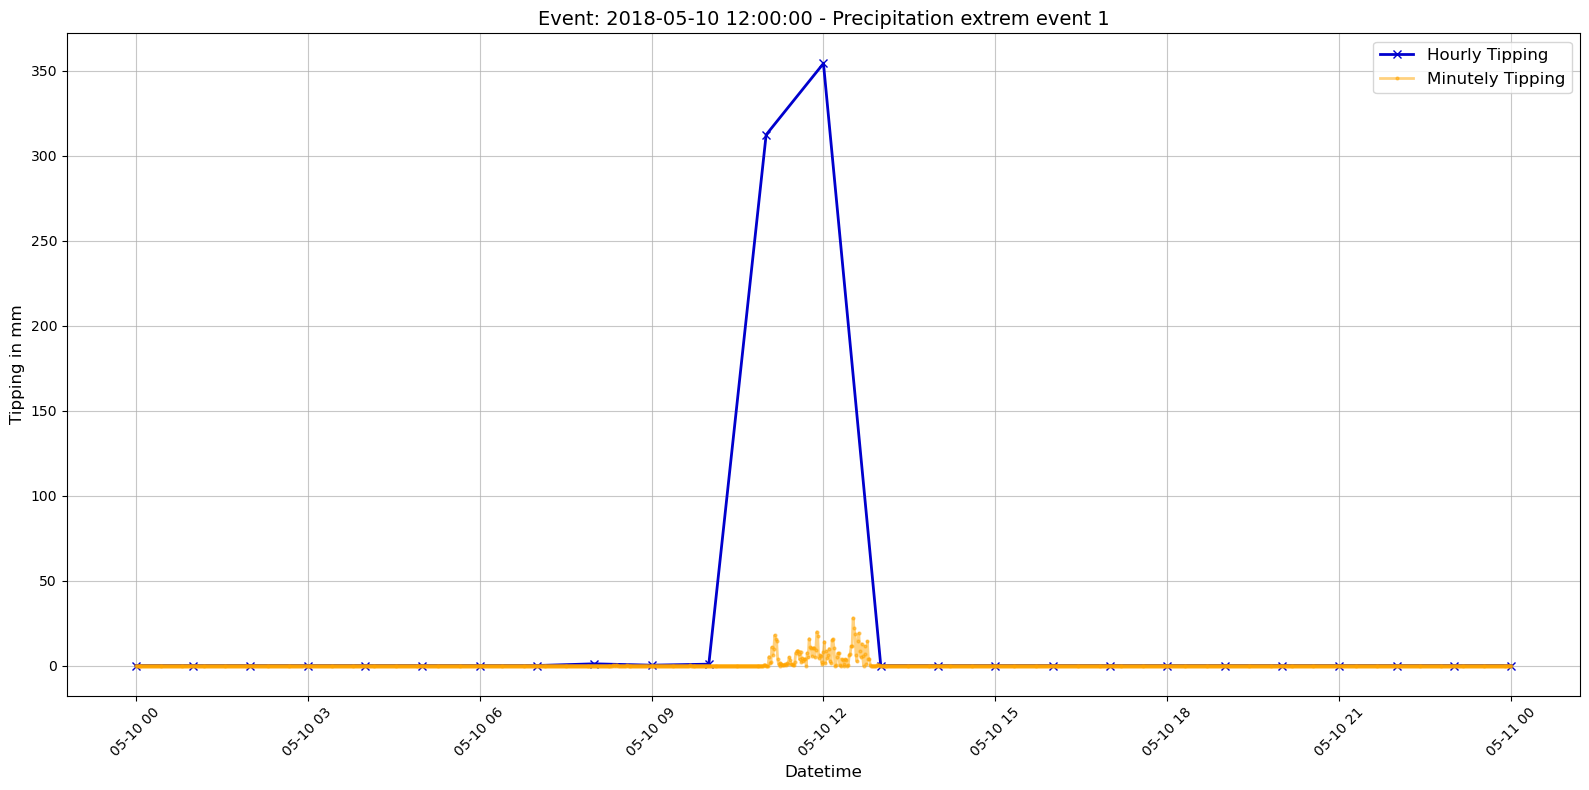

In [87]:
# Example Event 1
event_1 = pd.Timestamp("2018-05-10 12:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 1",
    save_fig=False
)

In [90]:
vienna_geopherestation_df.max()

station    5925.0
ff           13.4
rr           39.1
rrm          60.0
rr_flag      10.0
tl           38.5
dtype: float64

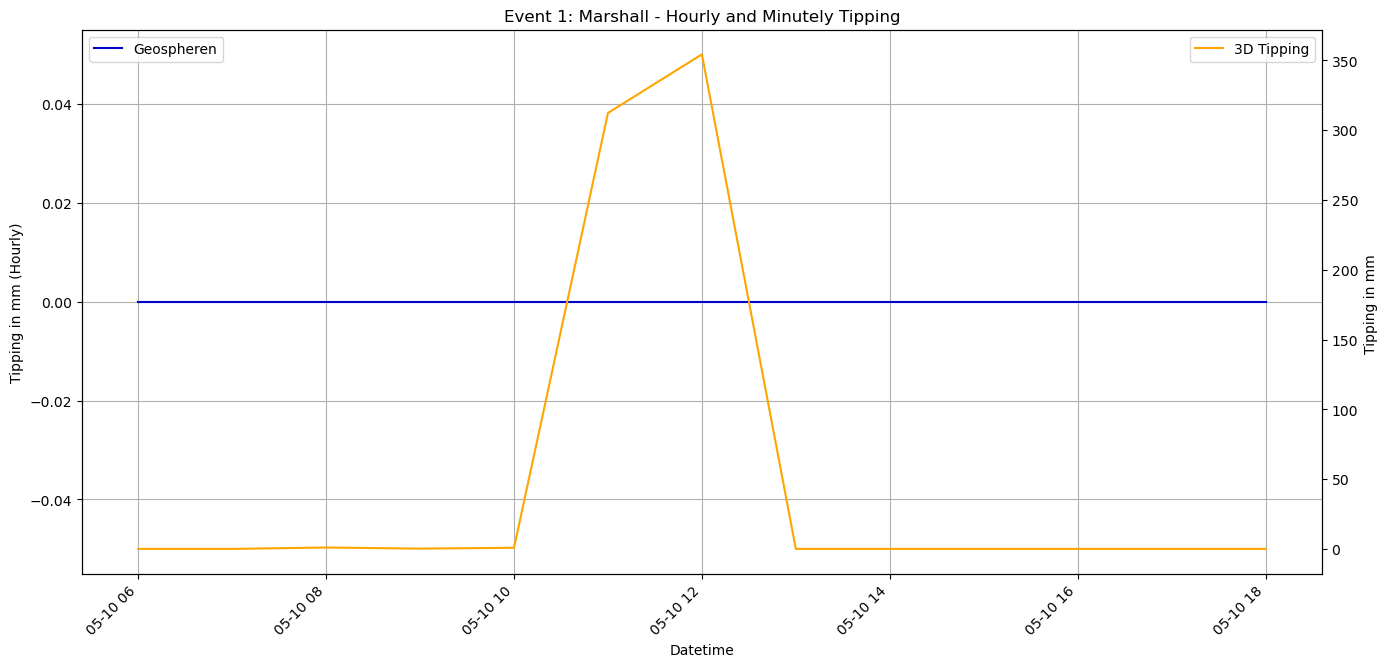

In [92]:
# Create the figure and the first axis

event_1 = pd.Timestamp("2018-05-10 12:00:00")

# measured 468 l/m2 in 1 h and the following hour measured 105 l/m2
# utc in local time 10:00

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_1 - time_delta) & (vienna_geopherestation_df.index <= event_1 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_1 - time_delta) & (vienna_hourly_df.index <= event_1 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 1: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()

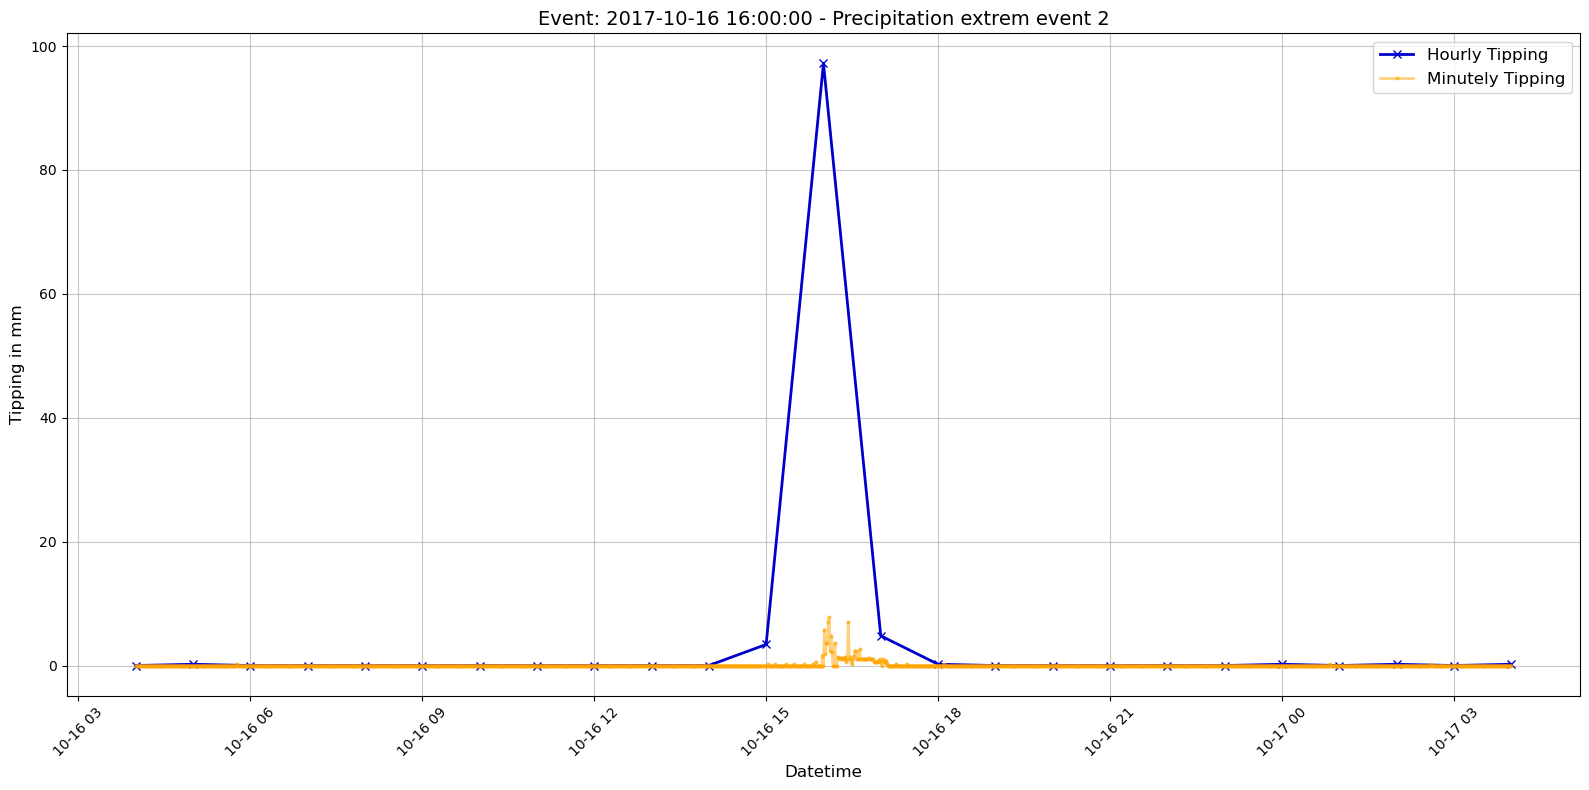

In [93]:
# Example Event 1
event_2 = pd.Timestamp("2017-10-16 16:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 2",
    save_fig=False
)

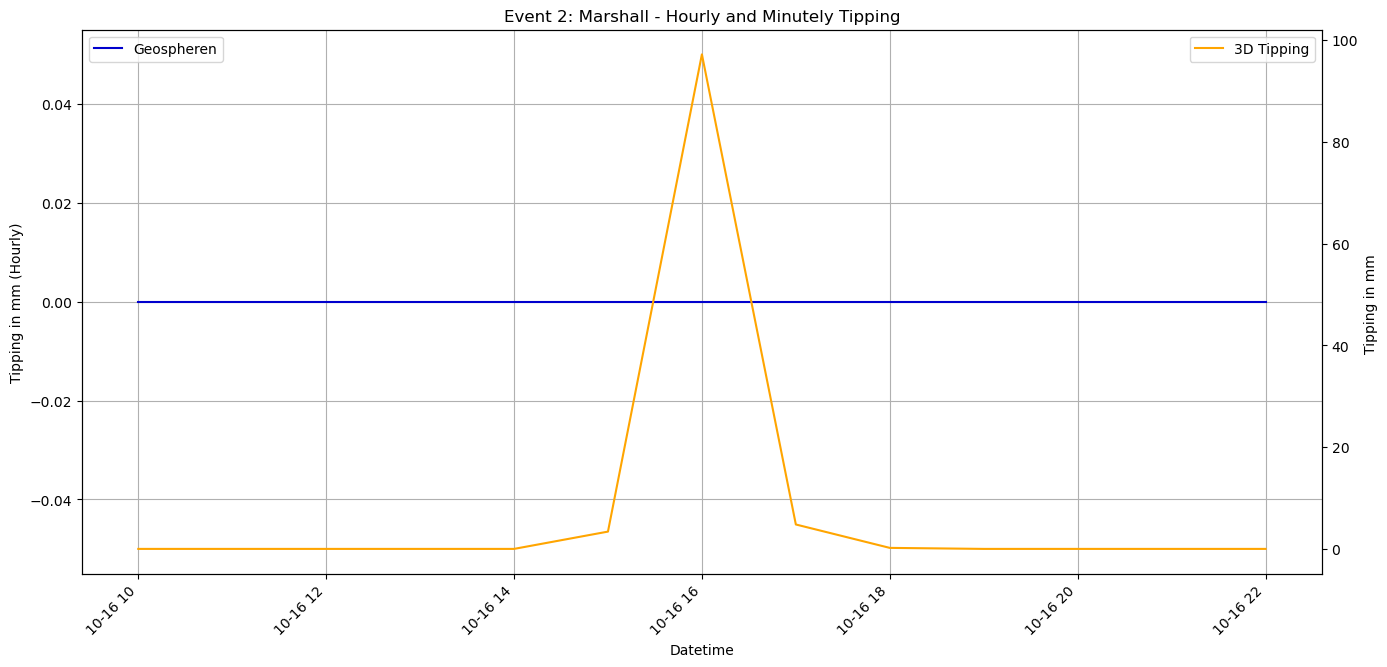

In [96]:
# Create the figure and the first axis
event_2 = pd.Timestamp("2017-10-16 16:00:00")

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_2 - time_delta) & (vienna_geopherestation_df.index <= event_2 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_2 - time_delta) & (vienna_hourly_df.index <= event_2 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 2: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()

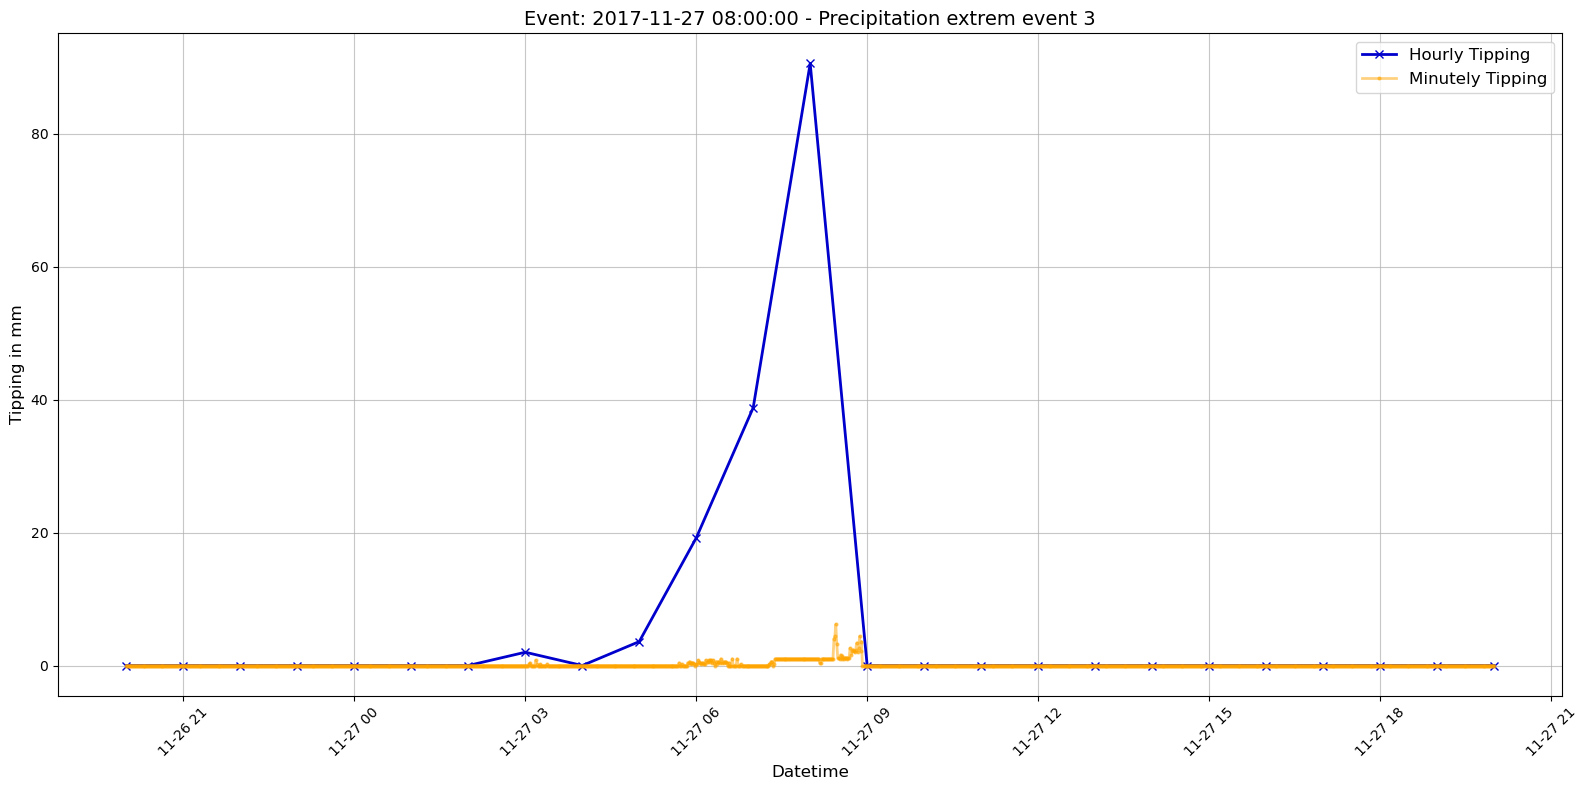

In [97]:
# Example Event 1
event_3 = pd.Timestamp("2017-11-27 08:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 3",
    save_fig=False
)

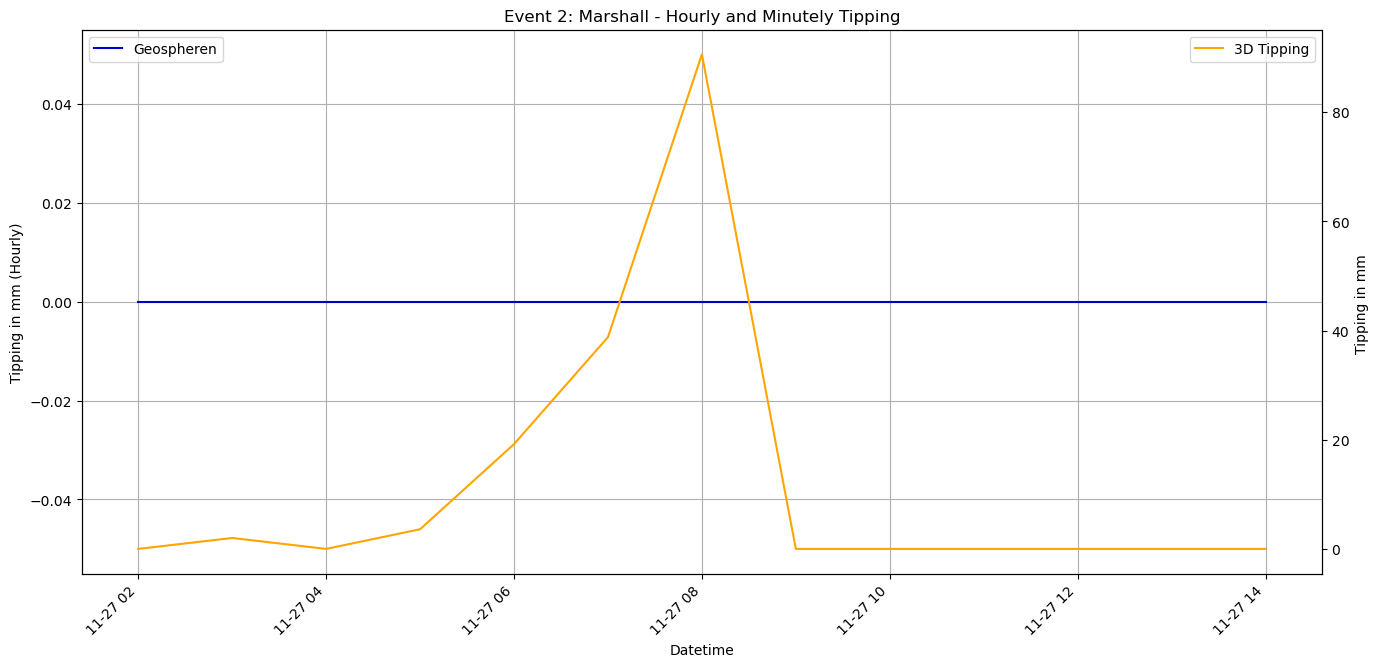

In [98]:
# Create the figure and the first axis

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_3 - time_delta) & (vienna_geopherestation_df.index <= event_3 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_3 - time_delta) & (vienna_hourly_df.index <= event_3 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 2: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()